In [1]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import os
import random
import numpy as np
import threading
from PIL import Image
from skimage import io, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Model, load_model
from keras.optimizers import *
from keras.layers import *
from keras.layers.core import Lambda
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing import image
from imagenet_utils import _obtain_input_shape
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# We need only the conv part of VGG
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_mean = (103.939, 116.779, 123.68)
greyscale_image_mean = np.mean(image_mean)

Using TensorFlow backend.


In [2]:
def create_model():

    # Determine proper input shape
    input_shape = _obtain_input_shape(None, default_size=224, min_size=48, data_format=K.image_data_format(), include_top=False)
    inputs = Input(shape=input_shape)
    
    # Encoder 1
    e11 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    e12 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(e11)
    e13 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(e12)

    # Encoder 2
    e21 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(e13)
    e22 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(e21)
    e23 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(e22)

    # Encoder 3
    e31 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(e23)
    e32 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(e31)
    e33 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(e32)
    e34 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(e33)

    # Encoder 4
    e41 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(e34)
    e42 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(e41)
    e43 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(e42)
    e44 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(e43)

    # Encoder 5
    e51 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(e44)
    e52 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(e51)
    e53 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(e52)
    e54 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(e53)
    
    # *********************************************************************************** #
    # Now lets decode the representation                                                  #
    # Using residual connections (in this case concatenate)                               #
    # *********************************************************************************** #

    # Decoder 5
    d51 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv1')(e54)
    d52 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv2')(d51)
    d53 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv3')(d52)
    d54 = UpSampling2D((2, 2), name='block5_upsample')(d53)
    
    # Decoder 4
    merged = concatenate([d54, e44])
    d41 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv1')(merged)
    d42 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv2')(d41)
    d43 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv3')(d42)
    d44 = UpSampling2D((2, 2), name='block4_upsample')(d43)
    
    # Decoder 3
    merged = concatenate([d44, e34])
    d31 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv1')(merged)
    d32 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv2')(d31)
    d33 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv3')(d32)
    d34 = UpSampling2D((2, 2), name='block3_upsample')(d33)
    
    # Decoder 2
    merged = concatenate([d34, e23])
    d21 = Deconvolution2D(64, (3, 3), activation='relu', padding='same', name='block2_deconv1')(merged)
    d22 = Deconvolution2D(64, (3, 3), activation='relu', padding='same', name='block2_deconv2')(d21)
    d23 = UpSampling2D((2, 2), name='block2_upsample')(d22)
    
    # Decoder 1
    merged = concatenate([d23, e13])
    d11 = Deconvolution2D(32, (3, 3), activation='relu', padding='valid', name='block1_deconv1')(merged)
    d12 = Deconvolution2D(32, (4, 4), strides=2, activation='relu', padding='valid', name='block1_deconv2')(d11)
    
    d01 = Conv2D(16, (3, 3), activation='relu',    padding='valid', name='out1')(d12)
    d02 = Conv2D(2, (5, 5), activation='tanh', padding='valid', name='out2')(d01)
    out = Lambda(lambda x: x * 128.) (d02) # Map sigmoid to [-128; 128]


    
    # Create model.
    vgg16 = Model(inputs, e54, name='vgg16')
    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH_NO_TOP, cache_subdir='models')
    
    # Load weights of vgg16 and fix them (set non-trainable)
    vgg16.load_weights(weights_path)
    for l in vgg16.layers:
        l.trainable = False
    
    model = Model(inputs, out, name='colorizer')
    print( model.summary() )
    return model, vgg16

In [3]:
model, vgg = create_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [4]:
img = load_img('./dog.jpg', target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# res_first = first.predict([x], 1, verbose=1)
res_second = model.predict([x], 1, verbose=1)

# print(res_first[0].shape)
print(res_second[0].shape)

1/1 [==============================] - 4s
(224, 224, 2)


# Train

In [5]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [6]:
class BatchGenerator:

    def __init__(self, image_paths, batch_size, image_height, image_width, shuffle = True):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_height = image_height
        self.image_width = image_width
        self.lock = threading.Lock()
        self.index = 0
        if shuffle:
            random.shuffle(self.image_paths)

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            batch_features = np.zeros((self.batch_size, self.image_height, self.image_width, 3))
            batch_labels   = np.zeros((self.batch_size, self.image_height, self.image_width, 2))

            for i in range(self.batch_size):
                path = self.image_paths[self.index]
                
                image_gray = load_img(path, grayscale=True, target_size=(self.image_height, self.image_width))
                batch_features[i,:,:,0] = image_gray - greyscale_image_mean
                batch_features[i,:,:,1] = image_gray - greyscale_image_mean
                batch_features[i,:,:,2] = image_gray - greyscale_image_mean
                
                rgb_image = io.imread(path)
                rgb_image = resize(rgb_image, output_shape=(self.image_height, self.image_width, 3)) # Resize rgb image
                lab = color.rgb2lab(rgb)                                                             # Convert to Lab color space
                batch_labels[i] = lab[...,1:]                                                        # a, b channels are the targets
                
                self.index += 1
                if self.index >= len(self.image_paths):
                    self.index = 0
            return batch_features, batch_labels

In [7]:
# Define paths for train / validation / test datasets
train_root = '../coco/train2014/'
valid_root = '../coco/val2014/'
test_root = '../coco/test2014/'

train_image_paths = [train_root + item for item in os.listdir(train_root) if item.endswith('.jpg') ]
valid_image_paths = [valid_root + item for item in os.listdir(valid_root) if item.endswith('.jpg') ]
test_image_paths = [test_root + item for item in os.listdir(test_root) if item.endswith('.jpg') ]

print( 'Train:', len(train_image_paths) )
print( 'Validation:', len(valid_image_paths) )
print( 'Test:', len(test_image_paths) )

Train: 82783
Validation: 40504
Test: 40775


In [ ]:
batch_size = 37
train_data_generator = BatchGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)
valid_data_generator = BatchGenerator(image_paths=valid_image_paths, batch_size=batch_size, image_height=224, image_width=224)

print('There are', len(train_image_paths) / batch_size, 'steps per one train epoch for one complete cycle')
print('There are', len(valid_image_paths) / batch_size, 'steps per one validation epoch for one complete cycle')

checkpoint_path="../checkpoints/model-{epoch:03d}-{loss:.4f}.model"
model_saver = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='/tmp/coloring/')

model.fit_generator(generator=train_data_generator, 
                    steps_per_epoch = 500, # len(train_image_paths) / batch_size, 
                    validation_data=valid_data_generator, 
                    validation_steps = 33,
                    epochs=77,
                    callbacks=[tensorboard, model_saver], 
                    verbose=1)

# Evaluate

In [13]:
model = load_model('../checkpoints/model-000-730.5353.model')

In [14]:
path = './puma.jpg' # random.choice(test_image_paths)

rgb = io.imread(path)
rgb = resize(rgb, output_shape=(224, 224, 3))
image_gray = load_img(path, grayscale=True, target_size=(224, 224))
lab = color.rgb2lab(rgb)

inp = np.zeros((224, 224, 3))
inp[:,:,0] = image_gray - greyscale_image_mean
inp[:,:,1] = image_gray - greyscale_image_mean
inp[:,:,2] = image_gray - greyscale_image_mean

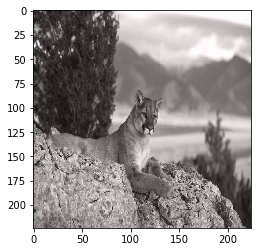

In [15]:
out = model.predict(np.array([inp]), batch_size=1)[0]

img = np.zeros((224, 224, 3))
img[:,:,0] = lab[...,0]
img[:,:,1:] = out

plt.imshow(color.lab2rgb(img))

# Experiments